In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import random 
import stormeunice as eun
import multiprocessing
import glob
from cmcrameri import cm
import metpy
from metpy.units import units
from matplotlib import gridspec
import matplotlib.transforms as mtransforms

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

sns.set_theme(style="white")
sns.set_style("white")
%matplotlib inline

random.seed(10)

# Import data

In [2]:
P1 = multiprocessing.Pool(40)

ifs_tracks = P1.map(eun.lagrangian.Lagrange.import_medr_tracks_TE, 
                    glob.glob('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_[!2]*'))

P1.close()

ifs_tracks = pd.concat(ifs_tracks)
ifs_tracks['date'] = pd.to_datetime(ifs_tracks.loc[:,['year','month','day','hour']])

## add era track in
era_track = pd.read_csv('/home/l/leach/Attribution/NA-Storms/Nick/Scripts/tracking/TE/TEStitch_2022_0',
                        skipinitialspace=True)

era_track['expid'] = 'era5'
era_track['experiment'] = 'era5'
era_track['inidate'] = pd.to_datetime('2022-01-01')
era_track['number'] = 0
era_track['date'] = pd.to_datetime(era_track.loc[:,['year','month','day','hour']])

all_tracks = pd.concat([ifs_tracks,era_track])

eunice_track = era_track.query('track_id==5')

In [3]:
ifs_tracks_filter = ifs_tracks.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min))
eunice_filter = eunice_track.groupby(['track_id','inidate','experiment','number']).agg(dict(date=min, day=np.size, lon=lambda x: x.iloc[0], lat=lambda x: x.iloc[0], msl=min)).iloc[0]

# starttime criterion - must be detected within 12 hours (before or after) the ERA5 track detectino time
starttime_crit = (ifs_tracks_filter.date - eunice_filter.date).dt.total_seconds().abs()<(12*60*60)
# starting location criterion - must start within 10 degrees of the ERA5 track starting point
startloc_crit = np.sqrt((ifs_tracks_filter.lon-eunice_filter.lon)**2+(ifs_tracks_filter.lat-eunice_filter.lat)**2)<10
# depth criterion - must reach a depth of at least 980 hPa
minmsl_crit = ifs_tracks_filter.msl < 98000

ifs_tracks_filtered = ifs_tracks_filter.loc[starttime_crit&startloc_crit&minmsl_crit]
ifs_eunice_list = ifs_tracks.set_index(['track_id','inidate','experiment','number']).sort_index().loc[ifs_tracks_filtered.index].reset_index()

In [4]:
multi_track_members = ifs_eunice_list.groupby(['inidate','experiment','number','track_id']).agg(dict(year = lambda x: 1)).groupby(['inidate','experiment','number']).count().query('year > 1')

for idx in multi_track_members.index:
    track_dists = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={}'.format(*idx)).groupby('track_id').apply(lambda x: eun.lagrangian.Lagrange.eunice_dist(x,eunice_track=eunice_track))
    num_reject = track_dists.idxmax()
    ifs_eunice_list_idx = ifs_eunice_list.query('inidate=="{}" & experiment=="{}" & number=={} & track_id=={}'.format(*idx,num_reject)).index
    ifs_eunice_list = ifs_eunice_list.drop(ifs_eunice_list_idx)

In [5]:
ERA5_tracks = pd.read_hdf('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/postproc/tracks/ERA5/EU025/sfc/2022.h5')
ERA5_eunice_track = ERA5_tracks.query('uid=="202202079"')

ERA5_data = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc').sel(time=ERA5_eunice_track.date.values)
ERA5_data['centroid_lon'] = ('time',(ERA5_eunice_track.long*4).round()/4)
ERA5_data['centroid_lat'] = ('time',(ERA5_eunice_track.lat*4).round()/4)

ERA5_eunice_stormframe = ERA5_data.groupby('time').apply(eun.lagrangian.Lagrange.lagrangian_frame)

In [6]:
%%capture 
# Ignore outputs

curr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')
pi_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/pl/pf/extravars/*.nc',
                              preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list, sfc=False),
                              combine='nested',
                              concat_dim=['inidate'],
                              parallel=True, 
                              engine='netcdf4')
incr_storms = xr.open_mfdataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/pl/pf/extravars/*.nc',
                                preprocess=lambda x: eun.lagrangian.Lagrange.preproc_to_stormframe_max_deepening(x, ifs_eunice_list=ifs_eunice_list,sfc=False),
                                combine='nested',
                                concat_dim=['inidate'],
                                parallel=True, 
                                engine='netcdf4')

# Calculations

In [7]:
# calculate eq potential temperature
experiments = ['pi', 'curr', 'incr']
eq_pot_temp = {}
storms = {'pi' : pi_storms, 'curr' : curr_storms, 'incr' : incr_storms}
pot_temp = {}
for exp in experiments:
    pot_temp[exp] = metpy.calc.potential_temperature(storms[exp].level * units.hPa, storms[exp].t * units.kelvin)
    # r = metpy.calc.relative_humidity_from_specific_humidity(storms[exp].level * units.hPa, storms[exp].t * units.kelvin, storms[exp].q)
    # dewpoint = metpy.calc.dewpoint_from_relative_humidity(storms[exp].t * units.kelvin, r)

    # eq_pot_temp[exp] = metpy.calc.equivalent_potential_temperature(storms[exp].level * units.hPa, storms[exp].t * units.kelvin, dewpoint)

In [8]:
plev = 850
notmissing = np.load('11_members_with_complete_data_in_z_2022-02-14_plev'+str(plev)+'.npz')

# Significance testing

In [9]:
def generate_boot_2sided(test, comp, n_boot=10000, sign_lev=0.9, diff_larger_0=True):
    
    '''
    Two sample bootstrap for the mean of two datasets
    '''

    x = test.values  # three dimensional array: number, lat, lon
    y = comp.values

    #Brute force
    x_sign =  np.full((x.shape[1], x.shape[2]), 0)
    for lon in range(x.shape[1]):
        for lat in range(x.shape[2]):
            x_boot = np.random.choice(x[:, lon,lat], size=(n_boot, x.shape[0]), replace=True)
            y_boot = np.random.choice(y[:, lon,lat], size=(n_boot, x.shape[0]), replace=True)

            diff = np.mean(y_boot, axis=1) - np.mean(x_boot, axis=1)
            ci_lower = np.percentile(diff, 1-sign_lev)
            ci_upper = np.percentile(diff, sign_lev)
            if diff_larger_0 & (ci_lower>0):
                x_sign[lon, lat] = 1
            elif (not diff_larger_0) & (ci_upper<0):
                x_sign[lon, lat] = 1
    return x_sign

def in_interval(test, bounds):
    return (test > bounds[0]) and (test < bounds[1])

In [10]:
def generate_boot_1sided(test, n_boot=10000, sign_lev=0.9):
    
    '''
    One sample bootstrap for the mean of a dataset
    Q: is the mean different from 0?
    '''

    x = test.values  # three dimensional array: number, lat, lon

    #Brute force
    x_sign =  np.full((x.shape[1], x.shape[2]), 0)
    for lon in range(x.shape[1]):
        for lat in range(x.shape[2]):
            x_boot = np.random.choice(x[:,lon,lat], size=n_boot, replace=True)
            ci_lower = np.nanpercentile(x_boot, 100*(1-sign_lev)/2)
            ci_upper = np.nanpercentile(x_boot, 100*(sign_lev+(1-sign_lev)/2))
            if not in_interval(0, [ci_lower, ci_upper]):
                x_sign[lon, lat] = 1
    return x_sign

In [11]:
# Significance tests for specific humidity
ini = '2022-02-14'
ts = 0
pi = pi_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_pi']).squeeze().q
incr = incr_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_curr']).squeeze().q
test = incr -pi
sign_test_q = generate_boot_1sided(test)

In [12]:
# Significance tests for vorticity
ini = '2022-02-14'
ts = 0
pi = pi_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().squeeze().vo
incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().squeeze().vo
test = incr - pi
sign_test_vo = generate_boot_1sided(test)

# Plots

/tmp/user/27529/ipykernel_2504999/163384011.py:127: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axes[3].contourf(curr.storm_lon.values, curr.storm_lat.values, sign_test_q, alpha=0, levels=[-0.5,0.5,1],hatches=[None,'..'], add_colorbar=False, zorder=21)


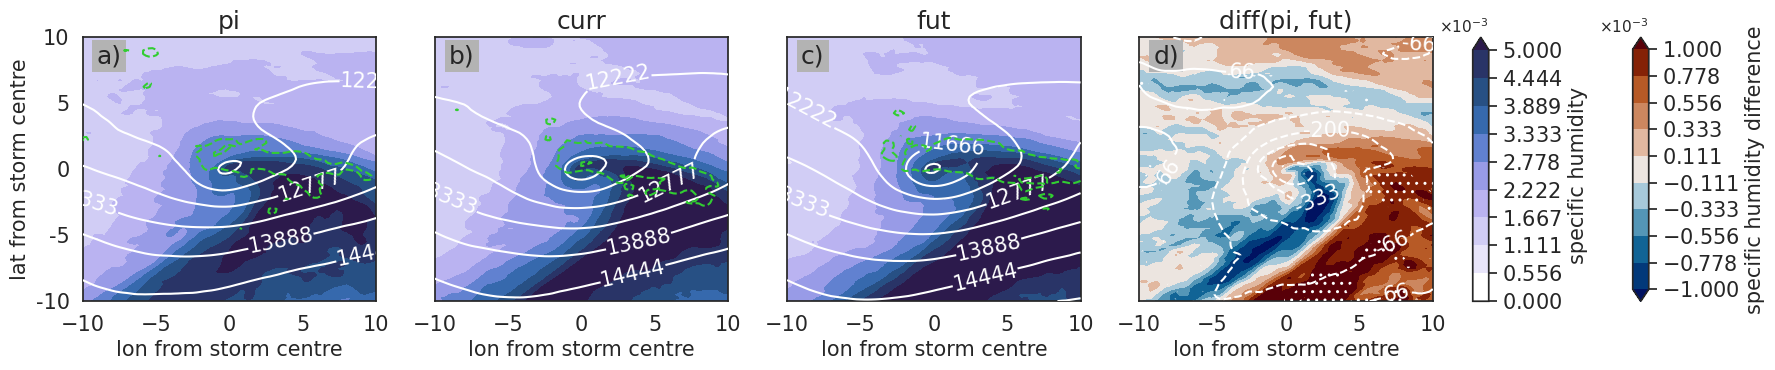

In [15]:
# setup -------------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 3.3), sharey=True)
fs = 18
vmin = 0
vmax = 0.005
lev_number = 10
ts = 0
ini = '2022-02-14'
z_min = 10000
z_max = 15000
num_levels_z = 10
w_min = -3
w_max = -0.5
num_levels_w = 2
plev = 850
labels = ['a)', 'b)', 'c)', 'd)']
plt.rcParams['hatch.linewidth'] = 1
plt.rcParams['hatch.color'] = 'white'

# pi -------------------------
pi = pi_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_pi']).squeeze().mean(dim = 'number')
c = pi.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('lat from storm centre', fontsize=fs-3)
axes[0].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[0].set_title('pi', fontsize=fs)
axes[0].tick_params(axis='both', which='major', labelsize=fs-3)

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[0].contour(pi.storm_lon.values, pi.storm_lat.values,
                     pi.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

# isolines for vertical velocities
clevs_w = np.linspace(w_min, w_max, num_levels_w) 
cs = axes[0].contour(pi.storm_lon.values, pi.storm_lat.values,
                     pi.w,
                     clevs_w, colors='limegreen',
                     zorder = 19)

# y axis number formatting
majorLocator2   = MultipleLocator(5)
majorFormatter2 = FormatStrFormatter('%d')
minorLocator2   = MultipleLocator(5)
axes[0].yaxis.set_major_locator(majorLocator2)
axes[0].yaxis.set_major_formatter(majorFormatter2)
axes[0].yaxis.set_minor_locator(minorLocator2)

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
axes[0].text(0.0, 1.0, labels[0], transform=axes[0].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# curr -------------------------
curr = curr_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_curr']).squeeze().mean(dim = 'number')
curr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[1], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[1].set_title('curr', fontsize=fs)
axes[1].tick_params(axis='both', which='major', labelsize=fs-3)

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[1].contour(curr.storm_lon.values, curr.storm_lat.values,
                     curr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

# isolines for vertical velocities
clevs_w = np.linspace(w_min, w_max, num_levels_w) 
cs = axes[1].contour(curr.storm_lon.values, curr.storm_lat.values,
                     curr.w,
                     clevs_w, colors='limegreen',
                     zorder = 20)

axes[1].text(0.0, 1.0, labels[1], transform=axes[1].transAxes + trans,
    fontsize=fs, verticalalignment='top', 
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# incr -------------------------
incr = incr_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_incr']).squeeze().mean(dim = 'number')
incr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[2], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[2].set_title('fut', fontsize=fs)
axes[2].tick_params(axis='both', which='major', labelsize=fs-3)

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[2].contour(incr.storm_lon.values, incr.storm_lat.values,
                     incr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

# isolines for vertical velocities
clevs_w = np.linspace(w_min, w_max, num_levels_w) 
cs = axes[2].contour(incr.storm_lon.values, incr.storm_lat.values,
                     incr.w,
                     clevs_w, colors='limegreen',
                     zorder = 19)

axes[2].text(0.0, 1.0, labels[2], transform=axes[2].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# diff -------------------------
diff = incr - pi
c_diff = diff.q.plot.contourf(levels = lev_number, cmap=cm.vik, ax=axes[3], add_colorbar=False, vmin = -0.001, vmax = 0.001)
axes[3].set_ylabel('')
axes[3].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[3].set_title('diff(pi, fut)', fontsize=fs)
axes[3].tick_params(axis='both', which='major', labelsize=fs-3)

# isolines
clevs_p = np.linspace(-600, 600, num_levels_z) 
cs = axes[3].contour(diff.storm_lon.values, diff.storm_lat.values,
                     diff.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

# hatching for significance
axes[3].contourf(curr.storm_lon.values, curr.storm_lat.values, sign_test_q, alpha=0, levels=[-0.5,0.5,1],hatches=[None,'..'], add_colorbar=False, zorder=21)

axes[3].text(0.0, 1.0, labels[3], transform=axes[3].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# cbars -------------------------
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, height
cbar = plt.colorbar(c, cax=cax, label='specific humidity')
cax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
cbar.set_label(label='specific humidity', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = plt.axes([0.9, 0.1, 0.008, 0.8])
cbar_diff = plt.colorbar(c_diff, cax=cax_diff, label='specific humidity difference')
cax_diff.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
cbar_diff.set_label(label='specific humidity difference', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

plt.savefig('figures/PAPER4_1_q.png', bbox_inches='tight')
plt.savefig('figures/PAPER4_1_q.pdf', bbox_inches='tight')
plt.show()

/tmp/user/27529/ipykernel_2504999/3540277050.py:108: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  axes[3].contourf(curr.storm_lon.values, curr.level.values, sign_test_vo,  alpha=0, levels=[-0.5,0.5,1],hatches=[None,'..'], add_colorbar=False, zorder=19)


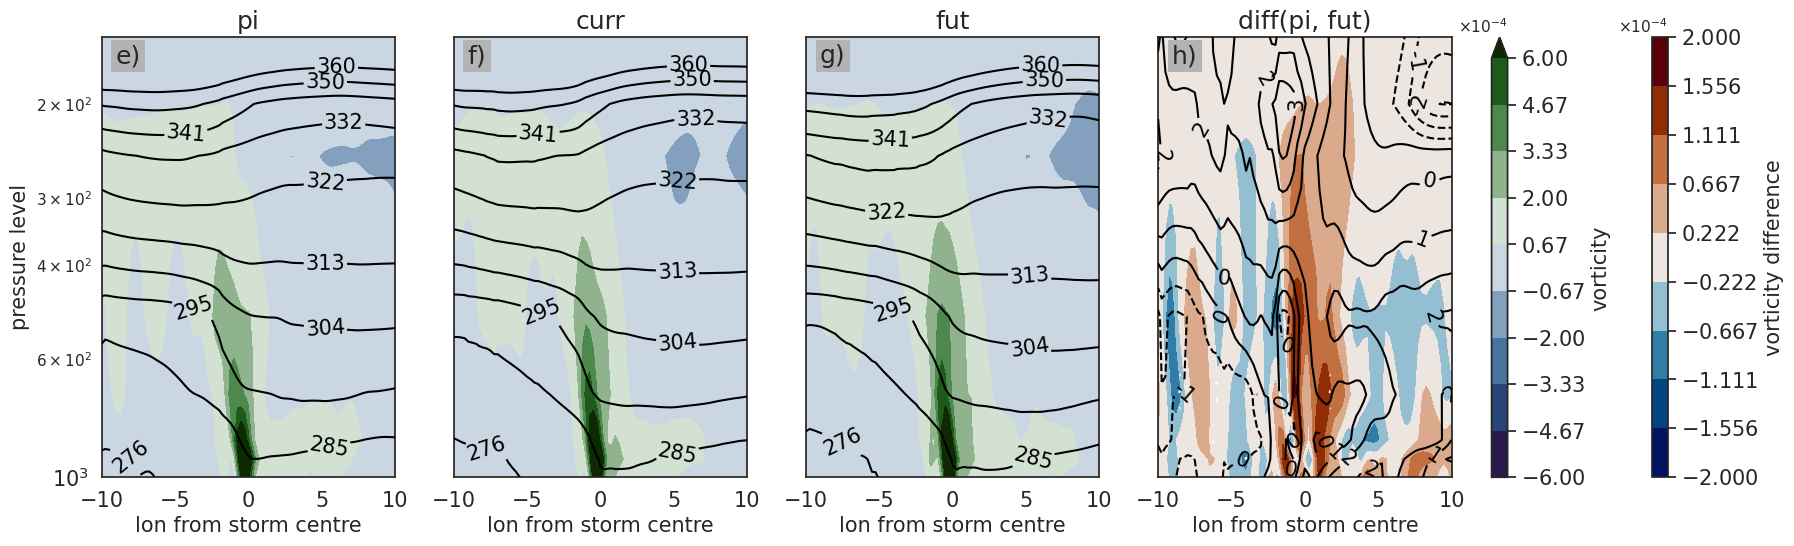

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5.5), sharey=True)
vmin = -0.0006
vmax = 0.0006
levs = 10
ts = 0
ini = '2022-02-14'
t_min = 230
t_max = 360
num_levels_t = 15
labels = ['e)', 'f)', 'g)', 'h)']

# pi ----------------------
pi = pi_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap=cm.cork, ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('pressure level', fontsize=fs-3)
axes[0].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[0].set_title('pi', fontsize=fs)
axes[0].set_ylim(150, 1000)
axes[0].tick_params(axis='both', which='major', labelsize=fs-3)
plt.yscale('log')
# axes[0].ticklabel_format(scilimits=(-4,4))

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[0].contour(pi.storm_lon.values, pi.level.values,
                     pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
axes[0].invert_yaxis()

# y axis number formatting
majorLocator2   = MultipleLocator(5)
majorFormatter2 = FormatStrFormatter('%d')
minorLocator2   = MultipleLocator(5)
axes[0].yaxis.set_major_locator(majorLocator2)
axes[0].yaxis.set_major_formatter(majorFormatter2)
axes[0].yaxis.set_minor_locator(minorLocator2)

trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
axes[0].text(0.0, 1.0, labels[0], transform=axes[0].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# curr ----------------------
curr = curr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
curr.vo.plot.contourf(ax=axes[1],levels=levs, cmap=cm.cork, vmin = vmin, vmax = vmax, add_colorbar=False)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[1].set_title('curr', fontsize=fs)
axes[1].set_ylim(150, 1000)
axes[1].tick_params(axis='both', which='major', labelsize=fs-3)
plt.yscale('log')
# axes[1].ticklabel_format(scilimits=(-4,4))

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[1].contour(pi.storm_lon.values, pi.level.values,
                     pot_temp['curr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
axes[1].invert_yaxis()

axes[1].text(0.0, 1.0, labels[1], transform=axes[1].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))
# incr ----------------------
incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
incr.vo.plot.contourf(ax=axes[2], levels=levs, cmap=cm.cork, vmin = vmin, vmax = vmax, add_colorbar=False)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[2].set_title('fut', fontsize=fs)
axes[2].set_ylim(150, 1000)
axes[2].tick_params(axis='both', which='major', labelsize=fs-3)
plt.yscale('log')
# axes[2].ticklabel_format(scilimits=(-4,4))

clevs_p = np.linspace(t_min, t_max, num_levels_t) 
cs = axes[2].contour(incr.storm_lon.values, incr.level.values,
                     pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)
axes[2].invert_yaxis()

axes[2].text(0.0, 1.0, labels[2], transform=axes[2].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# diff ----------------------
diff = incr - pi
c_diff = diff.vo.plot.contourf(ax=axes[3], levels=levs, cmap=cm.vik, vmin = -0.0002, vmax = 0.0002, add_colorbar=False)
axes[3].set_xlabel('lon from storm centre', fontsize=fs-3)
axes[3].set_ylabel('')
axes[3].set_title('diff(pi, fut)', fontsize=fs)
axes[3].set_ylim(150, 1000)
axes[3].tick_params(axis='both', which='major', labelsize=fs-3)
plt.yscale('log')
# axes[3].ticklabel_format(scilimits=(-4,4))

clevs_p = np.linspace(-5, 5, num_levels_t) 
cs = axes[3].contour(pi.storm_lon.values, pi.level.values,
                     pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze() - pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
                     clevs_p, colors='black',
                     zorder = 16)
plt.clabel(cs, fmt='%d', fontsize=fs-3)

# hatching for significance
axes[3].contourf(curr.storm_lon.values, curr.level.values, sign_test_vo,  alpha=0, levels=[-0.5,0.5,1],hatches=[None,'..'], add_colorbar=False, zorder=19)

axes[3].invert_yaxis()
axes[3].text(0.0, 1.0, labels[3], transform=axes[3].transAxes + trans,
    fontsize=fs, verticalalignment='top',
    bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0), zorder=21)

# cbars -------------------------
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, height
cbar = plt.colorbar(c, cax=cax, label='vorticity')
cax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
cbar.set_label(label='vorticity', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

cax_diff = plt.axes([0.9, 0.1, 0.008, 0.8])
cbar_diff = plt.colorbar(c_diff, cax=cax_diff, label='vorticity difference')
cax_diff.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))
cbar_diff.set_label(label='vorticity difference', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

plt.savefig('figures/PAPER4_2_vo.png', bbox_inches='tight')
plt.savefig('figures/PAPER4_2_vo.pdf', bbox_inches='tight')
plt.show()

# Putting the plots together

AttributeError: 'numpy.ndarray' object has no attribute 'contourf'

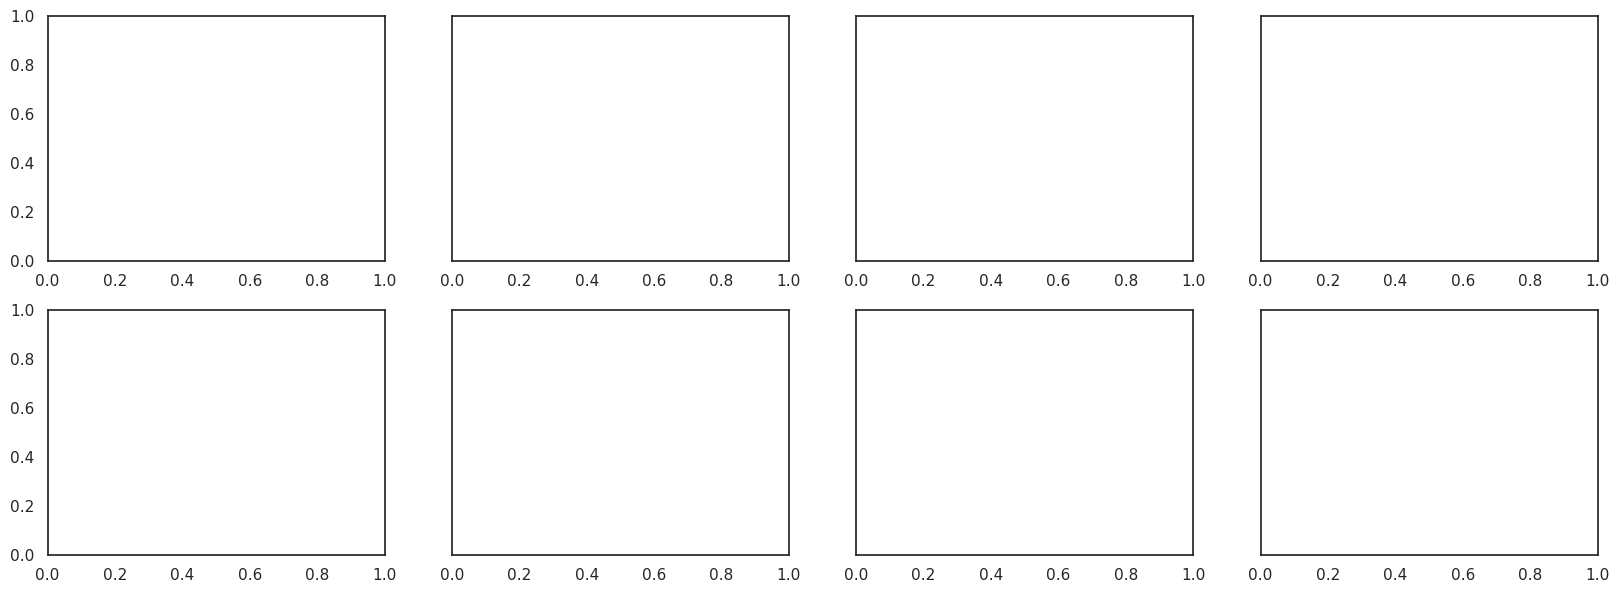

In [18]:
# setup -------------------------
fig, axes = plt.subplots(2, 4, figsize=(20, 7), sharey=True)
vmin = 0
vmax = 0.005
lev_number = 10
ts = 0
ini = '2022-02-14'
z_min = 10000
z_max = 15000
num_levels_z = 10
plev = 850
notmissing = np.load('11_members_with_complete_data_in_z_'+ini+'_plev'+str(plev)+'.npz')

# pi -------------------------
pi = pi_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_pi']).squeeze().mean(dim = 'number')
c = pi.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[0], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[0].set_ylabel('lat from storm centre')
axes[0].set_xlabel('lon from storm centre')
axes[0].set_title('pi')

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[0].contour(pi.storm_lon.values, pi.storm_lat.values,
                     pi.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# y axis number formatting
majorLocator2   = MultipleLocator(5)
majorFormatter2 = FormatStrFormatter('%d')
minorLocator2   = MultipleLocator(5)
axes[0].yaxis.set_major_locator(majorLocator2)
axes[0].yaxis.set_major_formatter(majorFormatter2)
axes[0].yaxis.set_minor_locator(minorLocator2)

# curr -------------------------
curr = curr_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_curr']).squeeze().mean(dim = 'number')
curr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[1], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[1].set_ylabel('')
axes[1].set_xlabel('lon from storm centre')
axes[1].set_title('curr')

# isolones
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[1].contour(curr.storm_lon.values, curr.storm_lat.values,
                     curr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# incr -------------------------
incr = incr_storms.sel(inidate=ini, timestep=ts, level=plev, number=notmissing['notmissing_incr']).squeeze().mean(dim = 'number')
incr.q.plot.contourf(levels = lev_number, cmap=cm.devon_r, ax=axes[2], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[2].set_ylabel('')
axes[2].set_xlabel('lon from storm centre')
axes[2].set_title('incr')

# isolines
clevs_p = np.linspace(z_min, z_max, num_levels_z) 
cs = axes[2].contour(incr.storm_lon.values, incr.storm_lat.values,
                     incr.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# diff -------------------------
diff = incr - pi
c_diff = diff.q.plot.contourf(levels = lev_number, cmap=cm.vik, ax=axes[3], add_colorbar=False, vmin = -0.001, vmax = 0.001)
axes[3].set_ylabel('')
axes[3].set_xlabel('lon from storm centre')
axes[3].set_title('diff(pi, incr)');

# isolines
clevs_p = np.linspace(-600, 600, num_levels_z) 
cs = axes[3].contour(diff.storm_lon.values, diff.storm_lat.values,
                     diff.z,
                     clevs_p, colors='white',
                     zorder = 16)
plt.clabel(cs, fmt='%d')

# cbars -------------------------
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, height
cbar = plt.colorbar(c, cax=cax, label='specific humidity')
cax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))

cax_diff = plt.axes([0.9, 0.1, 0.008, 0.8])
cbar_diff = plt.colorbar(c_diff, cax=cax_diff, label='specific humidity difference')
cax_diff.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))

#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------------

vmin = -0.0006
vmax = 0.0006
levs = 10
t_min = 230
t_max = 300
num_levels_t = 10

# pi ----------------------
pi = pi_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
c = pi.vo.plot.contourf(levels = levs, cmap=cm.cork, ax=axes[4], add_colorbar=False, vmin = vmin, vmax = vmax)
axes[4].set_ylabel('pressure level')
axes[4].set_xlabel('lon from storm centre')
axes[4].set_title('pi')

# clevs_p = np.linspace(t_min, t_max, num_levels_t) 
# cs = axes[4].contour(pi.storm_lon.values, pi.level.values,
#                      eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
#                      clevs_p, colors='black',
#                      zorder = 16)
# plt.clabel(cs, fmt='%d')
# axes[4].invert_yaxis()

# # curr ----------------------
# curr = curr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
# curr.vo.plot.contourf(ax=axes[5],levels=levs, cmap=cm.cork, vmin = vmin, vmax = vmax, add_colorbar=False)
# axes[5].set_ylabel('')
# axes[5].set_xlabel('lon from storm centre')
# axes[5].set_title('curr')

# clevs_p = np.linspace(t_min, t_max, num_levels_t) 
# cs = axes[5].contour(pi.storm_lon.values, pi.level.values,
#                      eq_pot_temp['curr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
#                      clevs_p, colors='black',
#                      zorder = 16)
# plt.clabel(cs, fmt='%d')
# axes[5].invert_yaxis()

# # incr ----------------------
# incr = incr_storms.sel(storm_lat = 0, inidate = ini, timestep = ts).squeeze().mean(dim = 'number')
# incr.vo.plot.contourf(ax=axes[6], levels=levs, cmap=cm.cork, vmin = vmin, vmax = vmax, add_colorbar=False)
# axes[6].set_ylabel('')
# axes[6].set_xlabel('lon from storm centre')
# axes[6].set_title('incr')

# clevs_p = np.linspace(t_min, t_max, num_levels_t) 
# cs = axes[6].contour(incr.storm_lon.values, incr.level.values,
#                      eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
#                      clevs_p, colors='black',
#                      zorder = 16)
# plt.clabel(cs, fmt='%d')
# axes[6].invert_yaxis()

# # diff ----------------------
# diff = incr - pi
# c_diff = diff.vo.plot.contourf(ax=axes[7], levels=levs, cmap=cm.vik, vmin = -0.0002, vmax = 0.0002, add_colorbar=False)
# axes[7].set_xlabel('lon from storm centre')
# axes[7].set_ylabel('')
# axes[7].set_title('diff(pi, incr)')

# clevs_p = np.linspace(-5, 5, num_levels_t) 
# cs = axes[7].contour(pi.storm_lon.values, pi.level.values,
#                      eq_pot_temp['incr'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze() - eq_pot_temp['pi'].sel(inidate=ini, storm_lat=0, timestep=ts).mean(dim='number').squeeze(),
#                      clevs_p, colors='black',
#                      zorder = 16)
# plt.clabel(cs, fmt='%d')
# axes[7].invert_yaxis()

# # cbars -------------------------
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

# cax = plt.axes([0.82, 0.1, 0.008, 0.8])  # left, bottom, width, height
# cbar = plt.colorbar(c, cax=cax, label='vorticity')
# cax.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))

# cax_diff = plt.axes([0.9, 0.1, 0.008, 0.8])
# cbar_diff = plt.colorbar(c_diff, cax=cax_diff, label='vorticity difference')
# cax_diff.ticklabel_format(style='scientific', useMathText=True, scilimits=(0,0))